In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib import colors
import pickle

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.dates as mdates

from os import listdir
from os.path import isfile, join

from functions_new import get_train_test
from functions_new import transformed_data
from functions_evaluation import diebold_mariano
from functions_plot import create_table
from functions_plot import create_name
from functions_plot import create_prediction_plot
from functions_plot import create_diebold_mariano_plot
from functions_plot import create_diebold_mariano_hourly_plot

from functions_plot import create_cumulative_error_plot
from functions_plot import create_coef_plot
from functions_plot import create_relative_cumulative_loss_plot
from functions_plot import get_date_range

import numpy.ma as ma
import datetime as dt
import pytz


In [2]:
models = {
    'Benchmark1': 'b1AR',
    'Benchmark2': 'b2AR',
    'Benchmark3': 'b3AR',
    'LASSOLago': 'LEAR',
    'LASSOall': 'LASSOLARS',
    'LASSOnw': 'nwLASSOLARS',
    'lightGBMallbayes': 'LGBM',
    'lightGBMnwbayes': 'nwLGBM',
    'LinBW': 'LinearBS',
    }

# Buffer plot to prevent erroneous short plots

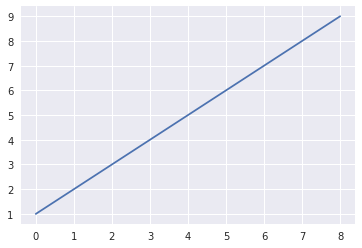

In [3]:
x=[1,2,3,4,5,6,7,8,9]
y=[1,2,3,4,5,6,7,8,9]
with plt.style.context('seaborn'):
    with plt.rc_context({'figure.figsize':(15,4)}):
        plt.plot(x)

# Results

In [4]:
create_table('Period1', models, nbest= 3)
create_table('Period2', models, nbest= 3)

\begin{table}
	\begin{center}
		\begin{tabular}{l|c|c|c|c|c}
			\textbf{Model} & \textbf{MAE} & \textbf{rMAE} & \textbf{MSE} & \textbf{MAPE} & \textbf{sMAPE} \\
			\hline
			$\text{b1AR}_{1095}$ & $9.102$ & $0.714$ & $160.392$ & $1.22\mathrm{e}+08$ & $0.365$ \\
			$\text{b2AR}_{1095}$ & $7.509$ & $0.589$ & $109.34$ & \cellcolor{grey!5}$8.56\mathrm{e}+07$ & $0.325$ \\
			$\text{b3AR}_{1095}$ & $6.893$ & $0.541$ & $97.027$ & $9.85\mathrm{e}+07$ & $0.309$ \\
			$\text{LASSOLARS}_{1095}$ & \cellcolor{grey!5}$6.473$ & \cellcolor{grey!5}$0.508$ & $86.535$ & $8.86\mathrm{e}+07$ & \cellcolor{grey!12}$0.296$ \\
			$\text{LEAR}_{1095}$ & \cellcolor{grey!20}$6.352$ & \cellcolor{grey!20}$0.499$ & \cellcolor{grey!20}$83.955$ & $8.69\mathrm{e}+07$ & \cellcolor{grey!20}$0.294$ \\
			$\text{LGBM}_{1095}$ & $6.787$ & $0.533$ & $92.526$ & \cellcolor{grey!20}$8.05\mathrm{e}+07$ & $0.302$ \\
			$\text{LinearBS}_{1095}$ & $6.49$ & $0.509$ & \cellcolor{grey!5}$85.306$ & $9.02\mathrm{e}+07$ & $0.298$ \\
			$

# Plots

## Data

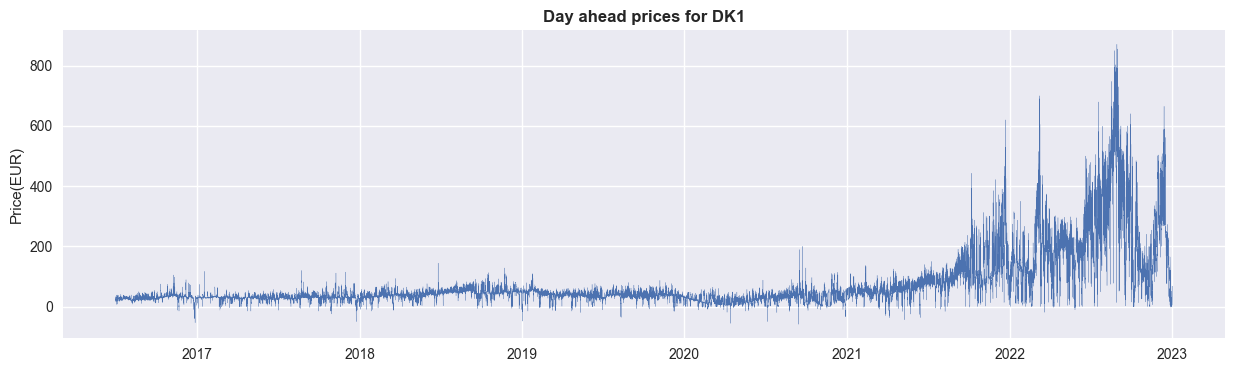

In [5]:
df = pd.read_csv("data/training_data.csv", sep = ";")
_, df_to_plot = get_train_test(df, [2016,7,1], [2023,1,1])
df_to_plot = df_to_plot.set_index(pd.to_datetime(df_to_plot['ValueDateTimeOffsetCET']))


default_figsize = plt.rcParams["figure.figsize"]

with plt.style.context('seaborn'):
    with plt.rc_context({'figure.figsize':(15,4)}):
        plt.plot(df_to_plot['PriceMWh'], linewidth= 0.2)
        plt.ylabel('Price(EUR)')
        plt.title('Day ahead prices for DK1', fontweight="bold")
        plt.savefig('plots/price.png', bbox_inches='tight')
        plt.show()


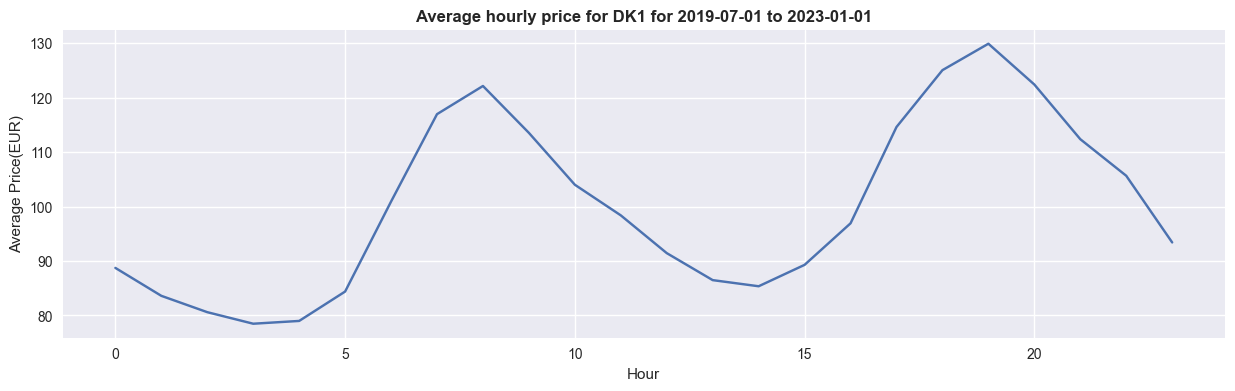

In [6]:
_, df_to_plot = get_train_test(df, [2019,7,1], [2023,1,1])
df_to_plot = df_to_plot.set_index(pd.to_datetime(df_to_plot['ValueDateTimeOffsetCET']))

means = []
for i in range(24):
    means.append(np.mean(df_to_plot[df_to_plot["HourCET"] == i]["PriceMWh"]))

with plt.style.context('seaborn'):
    with plt.rc_context({'figure.figsize':(15,4)}):
        plt.plot(means)
        plt.ylabel('Average Price(EUR)')
        plt.xlabel('Hour')
        plt.title('Average hourly price for DK1 for 2019-07-01 to 2023-01-01', fontweight="bold")
        plt.savefig('plots/avg_hourly_price.png', bbox_inches='tight')
        plt.show()

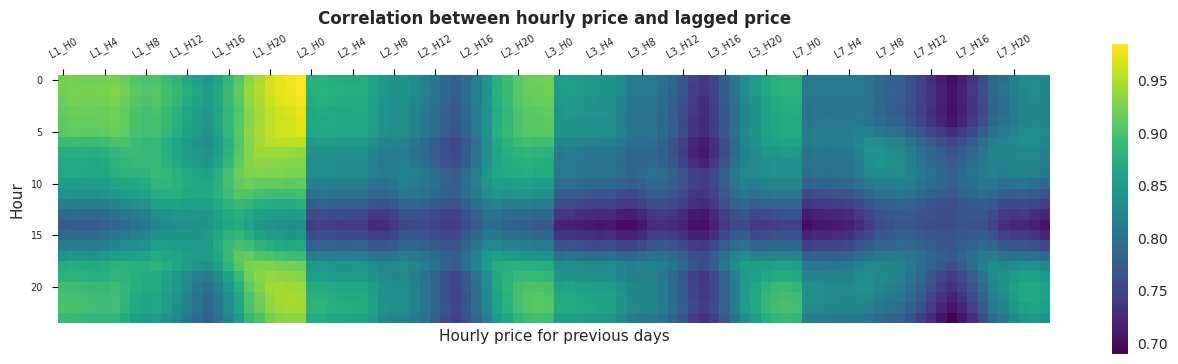

In [7]:
def corr_price_plot(lags, df):
    with plt.style.context('seaborn'):
        res = []
        for i in range(24):
            cur_df = df[df['HourCET']==i]
            hour_c = []
            xlab = []
            for lag in lags:
                for j in range(24):
                    cur_col = f'PriceMWh_lag{lag}_h{j}'
                    xlab.append(f'L{lag}_H{j}')
                    c = np.corrcoef(cur_df['PriceMWh'], cur_df[cur_col])
                    hour_c.append(c[1,0])
            res.append(hour_c)

        im = plt.matshow(res, cmap='viridis')
        plt.colorbar(im)
        plt.ylabel('Hour')
        plt.xlabel('Hourly price for previous days')
        plt.grid(False)
        plt.tick_params(axis='both', which='both', direction='out', length=4, width=0.8, color='black', bottom=False, top=True, left=True, right=False, labelsize=7)
        xtick = plt.xticks(range(0,len(xlab),4), xlab[::4], rotation=30)
        plt.title('Correlation between hourly price and lagged price', fontweight="bold")

corr_price_plot([1,2,3,7], df)
plt.savefig('plots/price_corr.png', bbox_inches='tight')
plt.show()

## Autocorrelation

c:\Users\louis\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


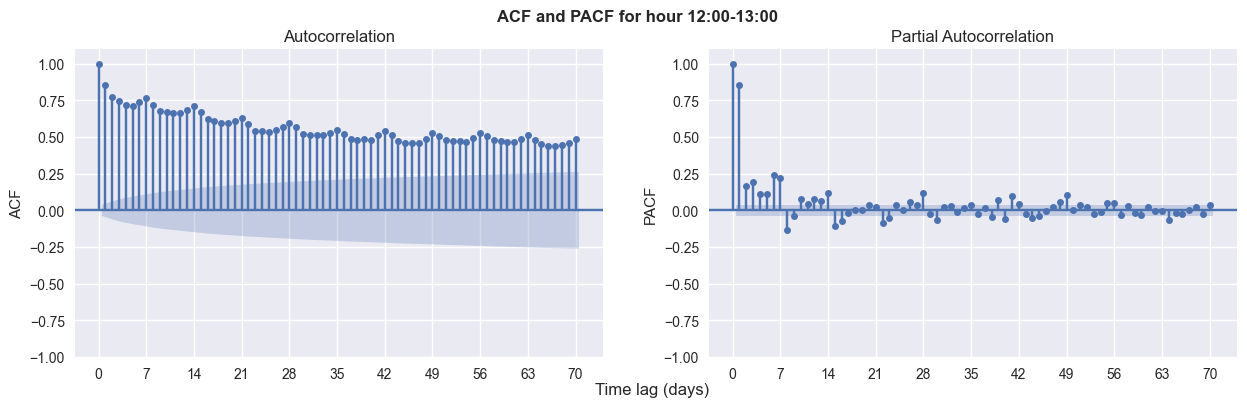

c:\Users\louis\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


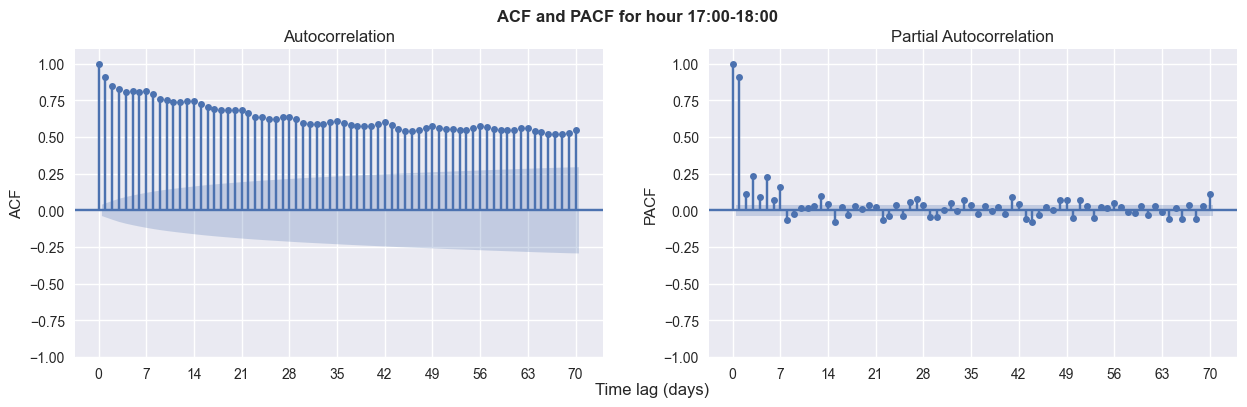

In [8]:
df = pd.read_csv("data/training_data.csv", sep = ";")

df_avg = df[df['HourCET']==12]
with plt.style.context('seaborn'):
    with plt.rc_context({'figure.figsize':(15,4)}):
        fig, (ax1, ax2) = plt.subplots(1,2)
        
        plot_acf(df_avg['PriceMWh'], lags=70, ax=ax1)
        ax1.xaxis.set_major_locator(plt.MultipleLocator(7))
        ax1.set_ylim(-1, 1.1)

        plot_pacf(df_avg['PriceMWh'], lags=70, ax=ax2)
        ax2.xaxis.set_major_locator(plt.MultipleLocator(7))
        ax2.set_ylim(-1, 1.1)

        ax1.set_ylabel("ACF")
        ax2.set_ylabel("PACF")

        fig.suptitle("ACF and PACF for hour 12:00-13:00", fontweight="bold")
        fig.supxlabel("Time lag (days)", x=0.51)
        #fig.supylabel("Value", x = 0.08)

        plt.savefig('plots/acf_12.png', bbox_inches='tight')
        plt.show()


df_avg = df[df['HourCET']==17]
with plt.style.context('seaborn'):
    with plt.rc_context({'figure.figsize':(15,4)}):
        fig, (ax1, ax2) = plt.subplots(1,2)
        
        plot_acf(df_avg['PriceMWh'], lags=70, ax=ax1)
        ax1.xaxis.set_major_locator(plt.MultipleLocator(7))
        ax1.set_ylim(-1, 1.1)

        plot_pacf(df_avg['PriceMWh'], lags=70, ax=ax2)
        ax2.xaxis.set_major_locator(plt.MultipleLocator(7))
        ax2.set_ylim(-1, 1.1)

        fig.suptitle("ACF and PACF for hour 17:00-18:00", fontweight="bold")
        fig.supxlabel("Time lag (days)", x=0.51)
        ax1.set_ylabel("ACF")
        ax2.set_ylabel("PACF")
        plt.savefig('plots/acf_17.png', bbox_inches='tight')
        plt.show()

## Diebold Mariano

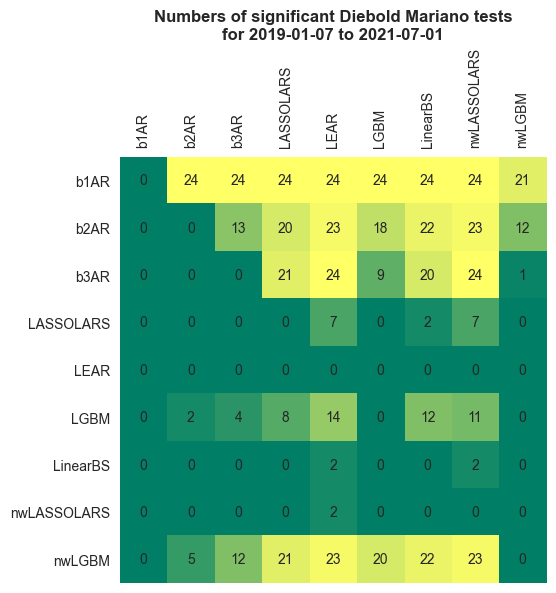

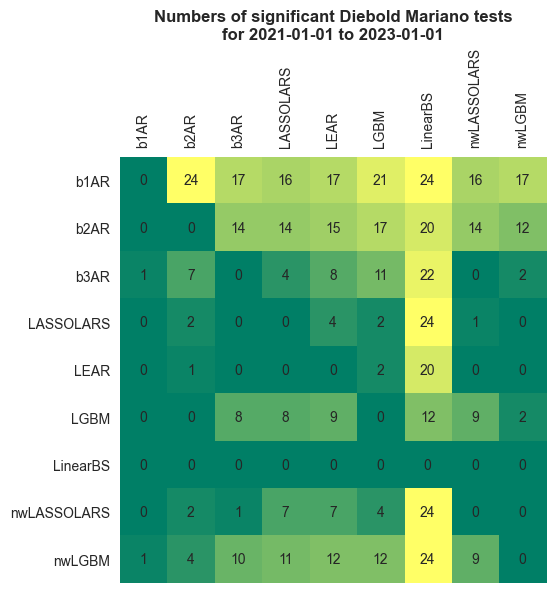

In [9]:
with plt.style.context('seaborn'):
    create_diebold_mariano_plot('Period1', models, norm=2)
    plt.grid(False)
    plt.savefig('plots/diebmar_p1.png', bbox_inches='tight')
    plt.show()

with plt.style.context('seaborn'):
    create_diebold_mariano_plot('Period2', models, norm=2)
    plt.grid(False)
    plt.savefig('plots/diebmar_p2.png', bbox_inches='tight')
    plt.show()

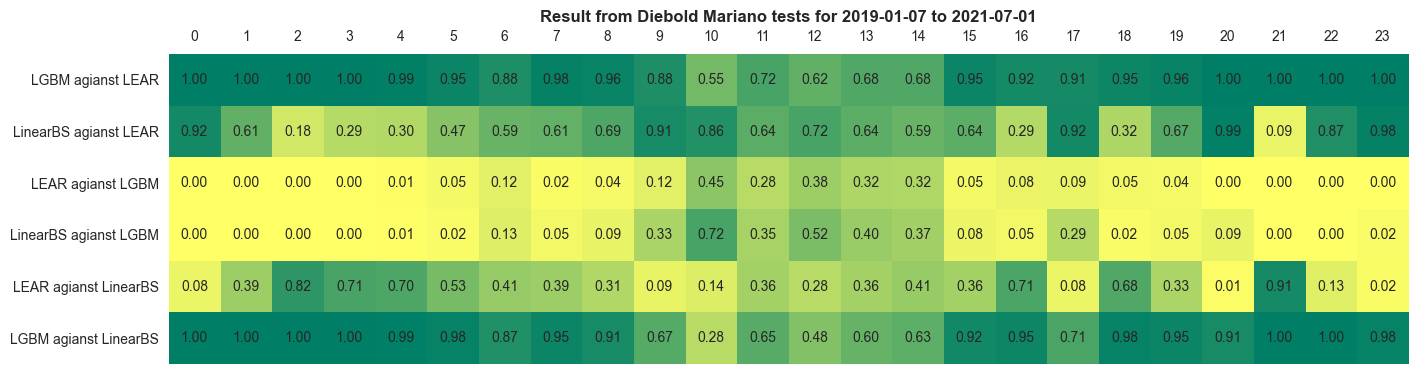

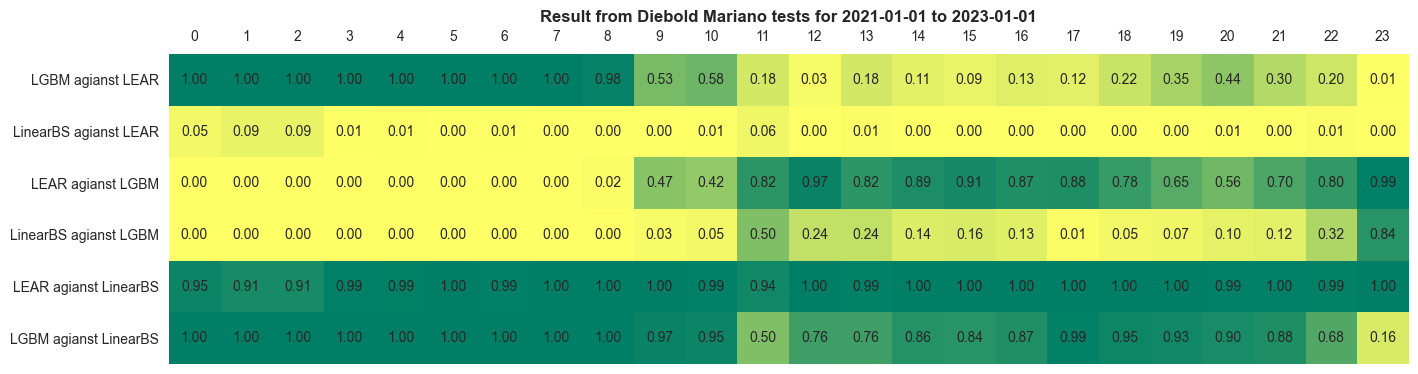

In [10]:
models_to_print=['LinearBS', 'LGBM', 'LEAR']
with plt.rc_context({'figure.figsize':(20,15)}):
    with plt.style.context('seaborn'):
        create_diebold_mariano_hourly_plot('Period1', models, norm=2, models_to_print=models_to_print)
        plt.grid(False)
        plt.savefig('plots/diebmar_h_p1.png', bbox_inches='tight')
        plt.show()

with plt.rc_context({'figure.figsize':(20,10)}):
    with plt.style.context('seaborn'):
        create_diebold_mariano_hourly_plot('Period2', models, norm=2, models_to_print=models_to_print)
        plt.grid(False)
        plt.savefig('plots/diebmar_h_p2.png', bbox_inches='tight')
        plt.show()

## Plot Error

In [11]:
def rsquared_lgbm(dt_start, dt_end, ax):
    with open ('results/training_set_results/lightGBMall_Period1_Year3.txt', 'rb') as fp:
            rs = pickle.load(fp)
    dates1 = pd.date_range(start='2019-07-01 00:00:00', periods=rs.shape[0], freq='1D', tz='CET') 
    df_dates_per1 = pd.DataFrame({'r-squared':rs}, index=dates1)

    with open ('results/training_set_results/lightGBMall_Period2_Year3.txt', 'rb') as fp:
        rs = pickle.load(fp)
    dates2 = pd.date_range(start='2020-01-01 00:00:00', periods=rs.shape[0], freq='1D', tz='CET') 
    df_dates_per2 = pd.DataFrame({'r-squared':rs}, index=dates2)

    if dt_end <= dates1[-1]:
        ax.plot(df_dates_per1['r-squared'].loc[dt_start: dt_end])

    elif dt_end <= dates2[-1]:
        ax.plot(df_dates_per2['r-squared'].loc[dt_start: dt_end])

def create_volatility_plot(df_to_plot, dt_start, dt_end, ax):
    delta_h = 1
    T = 336

    diff = (df_to_plot - df_to_plot.shift(delta_h))[1:]
    df_to_plot= df_to_plot**2
    rv = df_to_plot.groupby(pd.to_datetime(df_to_plot.index).date).agg('sum')

    n = len(diff[dt_start: dt_end])
    lw_v = np.interp(n, [1, 31000//24], [0.8, 0.7])

    return ax.plot(rv[dt_start:dt_end], linewidth=lw_v, color='tab:red')


def create_relative_cumulative_loss_plot(models, models_to_print, dt_start, dt_end, relative_benchmark  = "b1AR", norm = 2, lplt=False):
    locator = mdates.MonthLocator()
    fmt = mdates.DateFormatter('%b')

    def create_df_dates(files, model_name):
        periods = ["Period1", 'Period2']
        for i in range(len(periods)):
            for file in files:
                if periods[i] in file:
                    name = create_name(file, models)

                    if name != None and name in model_name:
                        if i == 0:
                            with open (join(path, file), 'rb') as fp:
                                y_pred_per1, y_true_per1 = pickle.load(fp)
                            dates = pd.date_range(start='2019-07-01 00:00:00', periods=y_true_per1.shape[0], freq='1H', tz='CET') 
                            df_dates_per1 = pd.DataFrame({'y_pred':y_pred_per1, 'y_true':y_true_per1}, index=dates)
                        else:
                            with open (join(path, file), 'rb') as fp:
                                y_pred_per2, y_true_per2 = pickle.load(fp)
                            dates = pd.date_range(start='2021-01-01 00:00:00', periods=y_true_per2.shape[0], freq='1H', tz='CET') 
                            df_dates_per2 = pd.DataFrame({'y_pred':y_pred_per2, 'y_true':y_true_per2}, index=dates)

        df_out = pd.concat([df_dates_per1, df_dates_per2.loc[df_dates_per1.index[-1] + pd.Timedelta(hours=1):]])
        return df_out
        
        
    path = 'results'
    files = [f for f in listdir(path) if isfile(join(path, f))]
    df_dates_bench = create_df_dates(files, relative_benchmark)
    
    if lplt:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(3,1)

    n = len(df_dates_bench['y_true'][dt_start: dt_end])
    lw_e = np.interp(n, [1, 31000], [0.7, 0.6])
    lw_p = np.interp(n, [1, 31000], [0.6, 0.2])

    for model in models_to_print:
        model_filename = [model_filename for model_filename, model_name in models.items() if model_name == model][0]
        model_files = [file for file in files if model_filename in file]
        df_dates = create_df_dates(files=model_files, model_name=model)
  
        if norm == 2:
            cLoss_pred = np.cumsum((df_dates['y_true']-df_dates['y_pred'])**2)/np.arange(1, len(df_dates['y_true'])+1)
            cLoss_bench = np.cumsum((df_dates_bench['y_true']-df_dates_bench['y_pred'])**2)/np.arange(1, len(df_dates['y_true'])+1)
        elif norm == 1:
            cLoss_pred = np.cumsum(np.abs(df_dates['y_true']-df_dates['y_pred']))/np.arange(1, len(df_dates['y_true'])+1)
            cLoss_bench = np.cumsum(np.abs(df_dates_bench['y_true']-df_dates_bench['y_pred']))/np.arange(1, len(df_dates['y_true'])+1)
        
        to_plot = 1 - cLoss_pred/cLoss_bench
        to_plot = to_plot.loc[dt_start: dt_end]
        ax1.plot(to_plot.index.values, to_plot.values, label=model, linewidth= lw_e)
    
    cap = 'Centered cumulative loss relative to ' + relative_benchmark + ' for ' + str(dt_start.date()) + ' to ' + str(dt_end.date())
    ax1.legend(loc='lower right', fontsize="x-small", ncol=3)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('RCMSE')
    ax1.set_title(cap, fontweight="bold")

    cap = 'Price for ' + str(dt_start.date()) + ' to ' + str(dt_end.date())
    ax2.plot(df_dates['y_true'][dt_start: dt_end], linewidth= lw_p)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price(EUR)')
    ax2.set_title(cap, fontweight="bold")

    create_volatility_plot(df_dates['y_true'], dt_start, dt_end, ax3)
    ax3.set_ylabel('Volatility')
    cap = 'Volatility measured as RV for ' + str(dt_start.date()) + ' to ' + str(dt_end.date())
    ax3.set_title(cap, fontweight="bold")

    if lplt:
        rsquared_lgbm(dt_start, dt_end, ax4)

    for ax in fig.get_axes():
        ax.label_outer()
        ax.xaxis.set_major_formatter(fmt)
        ax.xaxis.set_major_locator(locator)
    


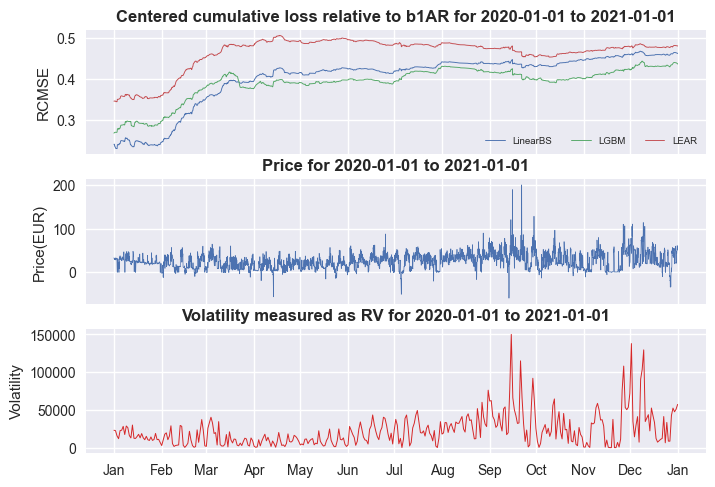

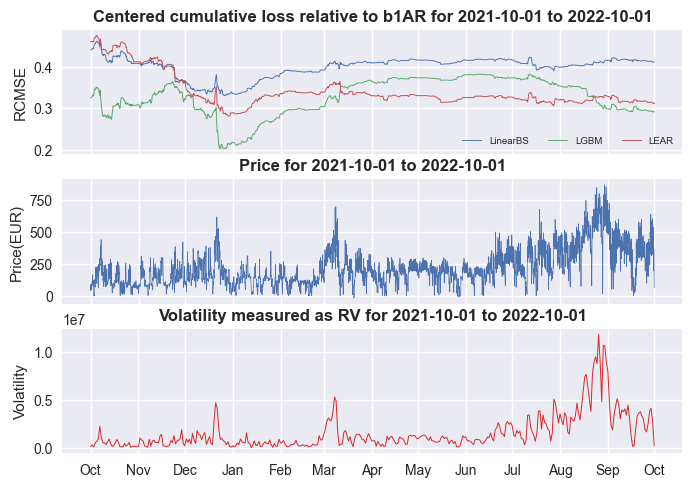

In [12]:
models_to_print=['LinearBS', 'LGBM', 'LEAR']

dt_start = pd.Timestamp("2020-01-01 00:00:00", tz="Europe/Copenhagen")
dt_end = pd.Timestamp("2021-01-01 00:00:00", tz="Europe/Copenhagen")

with plt.style.context('seaborn'):
    create_relative_cumulative_loss_plot(models, models_to_print, dt_start, dt_end, relative_benchmark  = "b1AR", lplt=False)
    plt.savefig('plots/vol_plot1', bbox_inches='tight')
    plt.show()

dt_start = pd.Timestamp("2021-10-01 00:00:00", tz="Europe/Copenhagen")
dt_end = pd.Timestamp("2022-10-01 00:00:00", tz="Europe/Copenhagen")

with plt.style.context('seaborn'):
    create_relative_cumulative_loss_plot(models, models_to_print, dt_start, dt_end, relative_benchmark  = "b1AR", lplt=False)
    plt.savefig('plots/vol_plot2.png', bbox_inches='tight')
    plt.show()

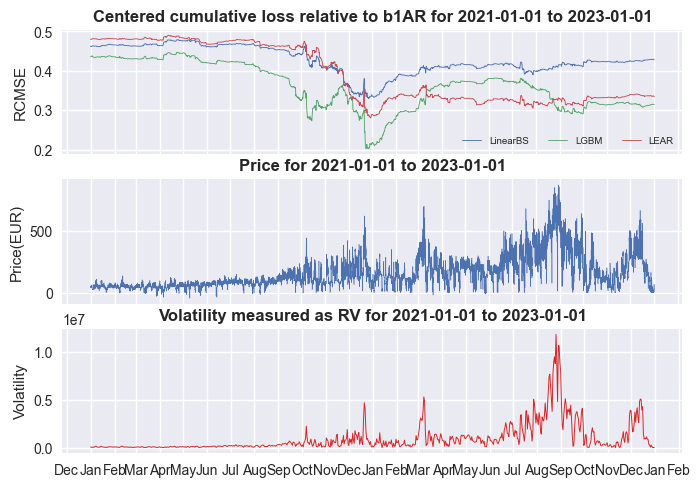

In [13]:
dt_start = pd.Timestamp("2021-01-01 00:00:00", tz="Europe/Copenhagen")
dt_end = pd.Timestamp("2023-01-01 00:00:00", tz="Europe/Copenhagen")

with plt.style.context('seaborn'):
    create_relative_cumulative_loss_plot(models, models_to_print, dt_start, dt_end, relative_benchmark  = "b1AR")
    plt.show()

# Examine variable selection

## Functions

In [14]:
def create_counts_subplot(df, grouped_variables, names, axs):
        m = len(names)

        k = 0
        for i, ax in enumerate(axs):
            variables = grouped_variables[i]
            median_counts = np.median(df[variables], axis = 0)
            cand = max(median_counts)
            if cand > k:
                k = cand
            ax.bar(np.arange(len(median_counts)), median_counts)
            ax.set_title(names[i])
            if len(range(0,len(median_counts), 4)) <= 2:
                ax.set_xticks(range(0,len(median_counts)))
            if len(range(0,len(median_counts), 4)) >= 12:
                ax.set_xticks(range(0,len(median_counts), 8))
            else:
                ax.set_xticks(range(0,len(median_counts),4))
            ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
            ax.margins(0)
        
        return k

def create_one_count_plot(df1, df2, grouped_variables, names, title):
    n = len(grouped_variables)

    with plt.style.context('seaborn'):
        with plt.rc_context({'figure.figsize':(20,4)}):
            p = 0.07
            ps = (1-p)/n*2
            ratio = [ps]*n + [p] + [ps]*n
            fig, axs = plt.subplots(1, 2*n+1, gridspec_kw={'width_ratios':ratio})

            k1 = create_counts_subplot(df1, grouped_variables, names, axs[0:n])
            k2 = create_counts_subplot(df2, grouped_variables, names, axs[n+1:2*n+1])

            axs[n].set_visible(False)

            for ax in fig.get_axes():
                ax.set_ylim(top = max(k1, k2) + 5)
                ax.label_outer()

            period1 = '2019-07-01 to 2021-07-01'
            period2 = '2021-01-01 to 2023-01-01'
        
            cap1 = f'For {period1}'
            cap2 = f'For {period2}'

            h = 0.88
            plt.text(.31, h, cap1, transform=fig.transFigure, horizontalalignment='center', size='x-large')
            plt.text(.71, h, cap2, transform=fig.transFigure, horizontalalignment='center', size='x-large')
            plt.text(.51, 0.95, title, transform=fig.transFigure, horizontalalignment='center', size='xx-large', fontweight='bold')

            fig.supylabel("Median amounts of splits", x=0.09)
            fig.supxlabel("Variables", y=0.0, x=0.51)
            fig.subplots_adjust(wspace=0.025, hspace=0.03, top=0.78)

def create_coef_subplot(dfs, grouped_variables, ticks, method, laxs):
    variables=[item for sublist in grouped_variables for item in sublist]
    set_title = True
    cmap = plt.get_cmap('viridis')
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.15, b=0.95), cmap(np.linspace(0.15, 0.95, 100)))
    ims = [0,0]
    for df, filename, axs in zip(dfs, method, laxs):
        n = max(df.max())

        if 'BW' in filename: model = 'LinearBS'
        if 'LARS' in filename: model = 'LASSOLARS'
        if 'LARSnw' in filename: model = 'nwLASSOLARS'
        if 'LEAR' in filename: model = 'LEAR'

        for i, ax in enumerate(axs):
            variables = grouped_variables[i]
            im = ax.matshow(df[variables], cmap=new_cmap, vmin=0, vmax=n, aspect="auto")
            if model == 'LASSOLARS': 
                ims[0] = im
            if model == 'LinearBS': 
                ims[1] = im
            
            ax.grid(False)
            if set_title:
                ax.set_title(ticks[i], rotation = 0, size='large')
            if i == 0:
                ax.set_ylabel(model, rotation=90, size='large')
            ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
        
        set_title = False

    return ims

def create_one_coef_plot(dfs1, dfs2, grouped_variables, names, method, title, c1=[1.1, 1.5, 0.1, 1], c2=[1.1, 0.25, 0.1, 0.5]):
    n = len(grouped_variables)
    m = len(dfs1)

    with plt.style.context('seaborn'):
        with plt.rc_context({'figure.figsize':(20,10)}):
            p = 0.07
            ps = (1-p)/n*2
            ratio = [ps]*n + [p] + [ps]*n
            fig, axs = plt.subplots(m, 2*n+1, gridspec_kw={'width_ratios':ratio})

            ims1 = create_coef_subplot(dfs1, grouped_variables, names, method, axs[0:m, 0:n])
            ims2 = create_coef_subplot(dfs2, grouped_variables, names, method, axs[0:m, n+1:2*n+1])
            
            for ax in axs[:,n]:
                ax.set_visible(False)

            for ax in fig.get_axes():
                ax.label_outer()

            period1 = '2019-07-01 to 2021-07-01'
            period2 = '2021-01-01 to 2023-01-01'
        
            cap1 = f'For {period1}'
            cap2 = f'For {period2}'


            h = 0.90
            plt.text(.31, h, cap1, transform=fig.transFigure, horizontalalignment='center', size='x-large')
            plt.text(.71, h, cap2, transform=fig.transFigure, horizontalalignment='center', size='x-large')
            plt.text(.51, 0.95, title, transform=fig.transFigure, horizontalalignment='center', size='xx-large', fontweight='bold')

            fig.supylabel("Hourly model", x=0.08)
            fig.supxlabel("Variables", y=0.05, x=0.51)
            fig.subplots_adjust(wspace=0.025, hspace=0.03, top=0.85)
            cax1 = ax.inset_axes(c1)
            cax2 = ax.inset_axes(c2)
            fig.colorbar(ims1[0], ax=axs[0:m-1,].ravel().tolist(), cax=cax1)
            fig.colorbar(ims1[1], ax=axs[m-1,].ravel().tolist(), cax=cax2)

            

## Make dfs

In [15]:
# Period 1
with open('results\coef_results\LASSOall_Period1_Year3.txt', 'rb') as fp:
    coeff, X_hourly = pickle.load(fp)
LARS_per1 = pd.DataFrame(coeff, columns=X_hourly[0])

X = X_hourly[0]

with open('results\coef_results\LASSOnw_Period1_Year3.txt', 'rb') as fp:
    coeff, X_hourly = pickle.load(fp)
LARSnw_per1 = pd.DataFrame(coeff, columns=X_hourly[0])

with open('results\coef_results\LASSOLago_Period1_Year3.txt', 'rb') as fp:
    coeff, X_hourly = pickle.load(fp)
LEAR_per1 = pd.DataFrame(coeff, columns=X_hourly[0])

with open('backward_result_2019.txt', 'rb') as fp:
    X_BW = pickle.load(fp)

out = np.zeros((24,len(X)))
for i in range(24):
    for j in range(len(X)):
        if X[j] in X_BW[i]:
            out[i,j] = 1
BW_per1 = pd.DataFrame(out, columns=X)



with open('results\coef_results\LightGBMallbayes_Period1_Year3.txt', 'rb') as fp:
    lightgbm_per1, X_gbm = pickle.load(fp)
lightgbm_per1 = pd.DataFrame(lightgbm_per1, columns = X_gbm)


# Period 2
with open('results\coef_results\LASSOall_Period2_Year3.txt', 'rb') as fp:
    coeff, X_hourly = pickle.load(fp)
LARS_per2 = pd.DataFrame(coeff, columns=X_hourly[0])

X = X_hourly[0]

with open('results\coef_results\LASSOnw_Period2_Year3.txt', 'rb') as fp:
    coeff, X_hourly = pickle.load(fp)
LARSnw_per2 = pd.DataFrame(coeff, columns=X_hourly[0])

with open('results\coef_results\LASSOLago_Period2_Year3.txt', 'rb') as fp:
    coeff, X_hourly = pickle.load(fp)
LEAR_per2 = pd.DataFrame(coeff, columns=X_hourly[0])

with open('backward_result_2021.txt', 'rb') as fp:
    X_BW = pickle.load(fp)

out = np.zeros((24,len(X)))
for i in range(24):
    for j in range(len(X)):
        if X[j] in X_BW[i]:
            out[i,j] = 1
BW_per2 = pd.DataFrame(out, columns=X)

with open('results\coef_results\LightGBMallbayes_Period2_Year3.txt', 'rb') as fp:
    lightgbm_per2, X_gbm = pickle.load(fp) 
lightgbm_per2 = pd.DataFrame(lightgbm_per2, columns = X_gbm)

## Make plots

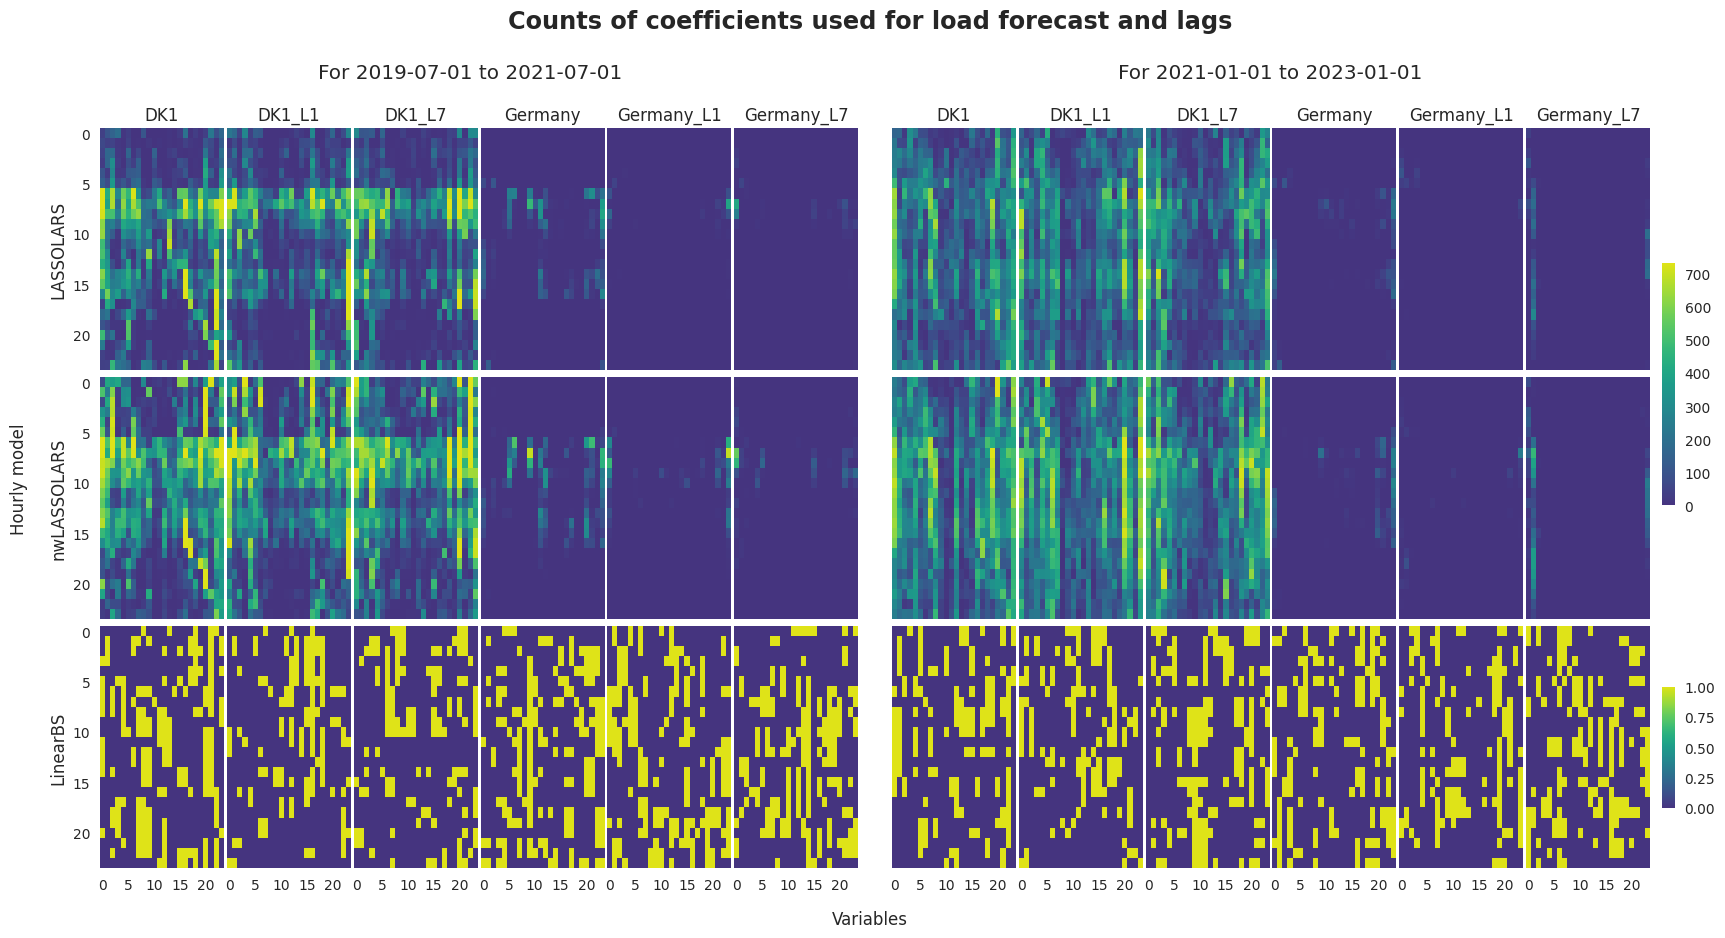

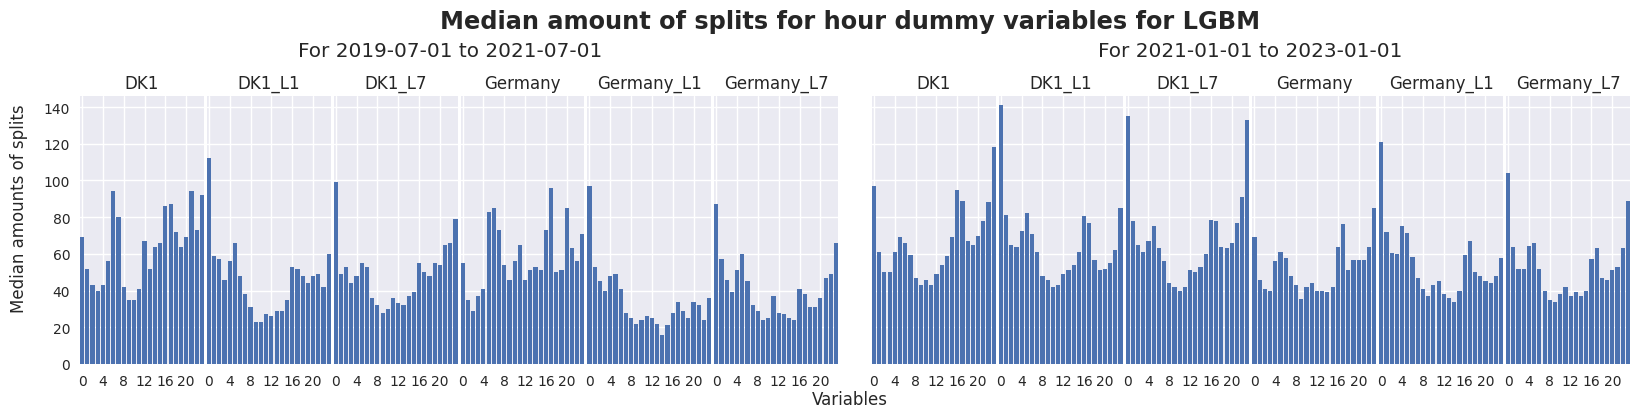

In [16]:

load_dk1 = [x for x in X if 'Grid' in x and 'DK1' in x and 'lag' not in x]
load_dk1_lag1 = [x for x in X if 'Grid' in x and 'DK1' in x and 'lag1' in x]
load_dk1_lag7 = [x for x in X if 'Grid' in x and 'DK1' in x and 'lag7' in x]

load_ger = [x for x in X if 'Grid' in x and 'Ger' in x and 'lag' not in x]
load_ger_lag1 = [x for x in X if 'Grid' in x and 'Ger' in x and 'lag1' in x]
load_ger_lag7 = [x for x in X if 'Grid' in x and 'Ger' in x and 'lag7' in x]

grouped_var = [load_dk1, load_dk1_lag1, load_dk1_lag7, load_ger, load_ger_lag1, load_ger_lag7]
names = ['DK1', 'DK1_L1', 'DK1_L7', 'Germany', 'Germany_L1', 'Germany_L7']
method = ['LARS', 'LARSnw','BW']
dfs_period1 = [LARS_per1, LARSnw_per1, BW_per1]
dfs_period2 = [LARS_per2, LARSnw_per2, BW_per2]
title = 'Counts of coefficients used for load forecast and lags'

create_one_coef_plot(dfs_period1, dfs_period2, grouped_var, names, method, title)
plt.savefig('plots/coeff_plot_load.png', bbox_inches='tight')
plt.show()

title = "Median amount of splits for hour dummy variables for LGBM"
create_one_count_plot(lightgbm_per1, lightgbm_per2, grouped_var, names, title)
plt.savefig('plots/count_plot_load.png', bbox_inches='tight')
plt.show()


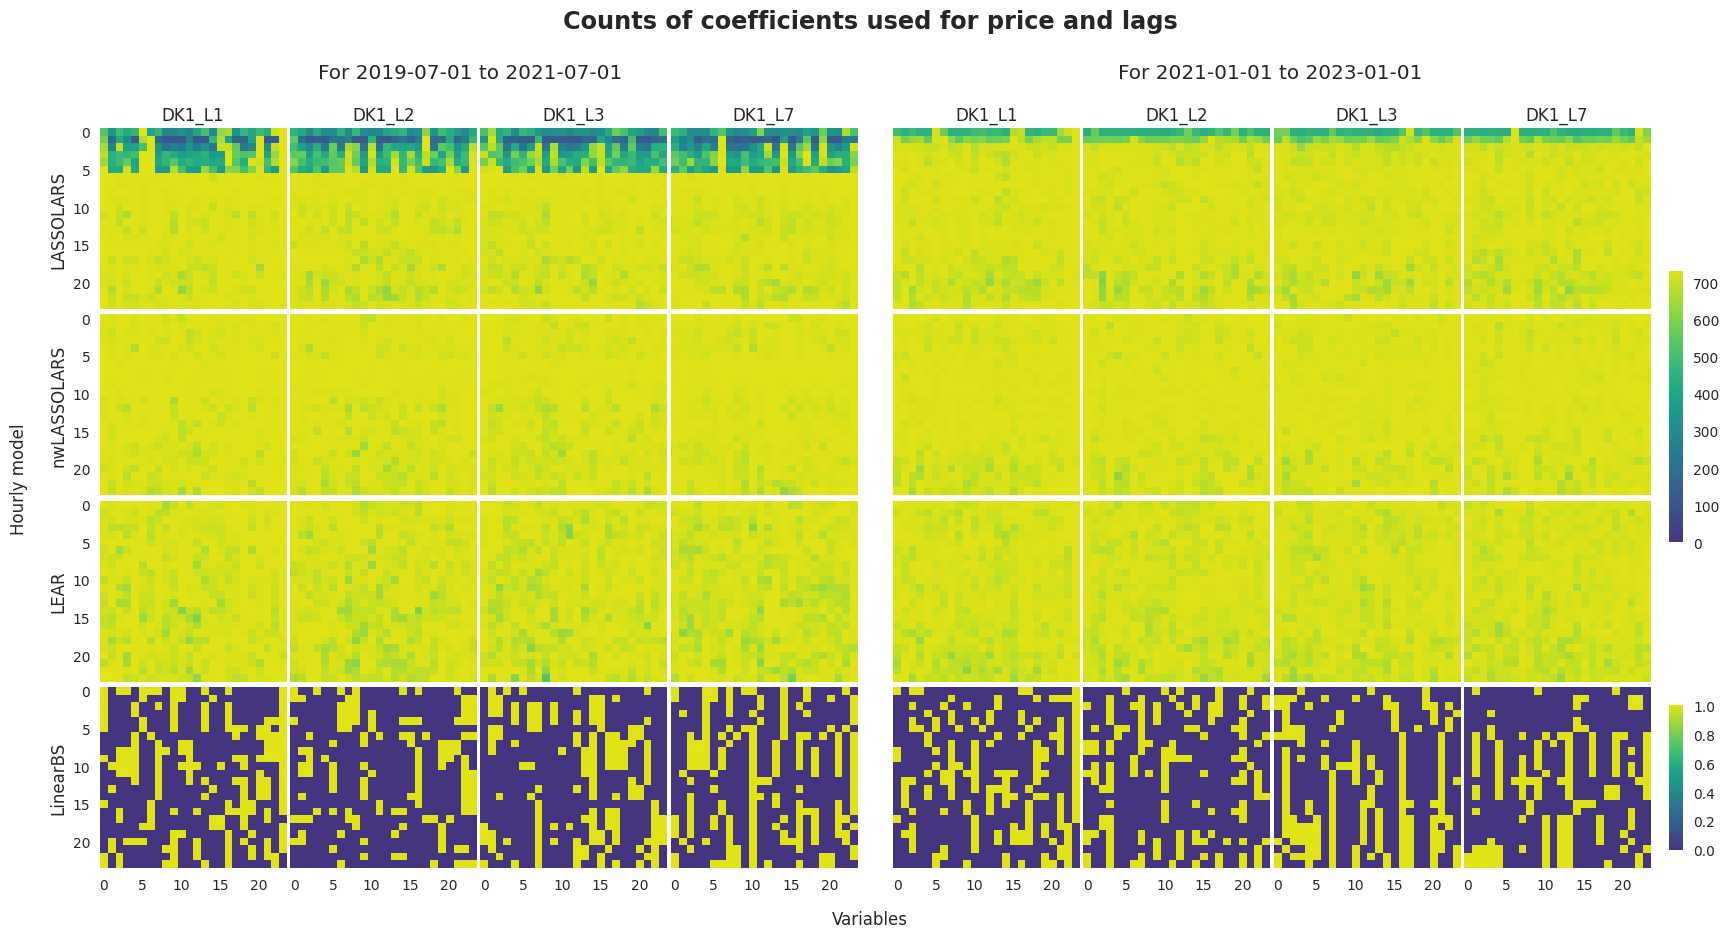

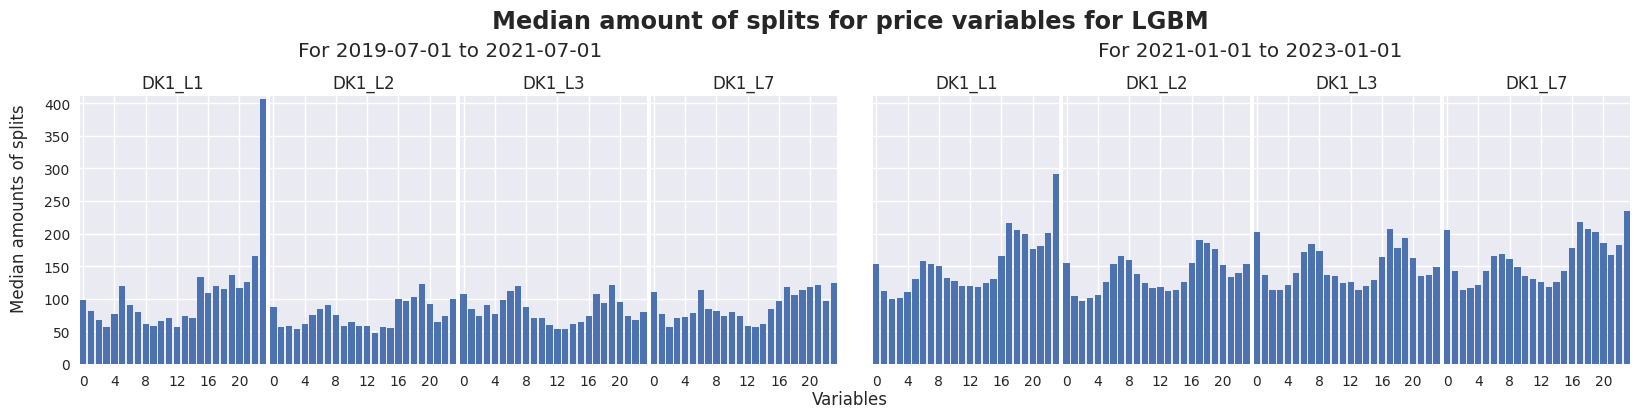

In [17]:
price_dk1_lag1 = [x for x in X if 'Price' in x and 'lag1' in x]
price_dk1_lag2 = [x for x in X if 'Price' in x and 'lag2' in x]
price_dk1_lag3 = [x for x in X if 'Price' in x and 'lag3' in x]
price_dk1_lag7 = [x for x in X if 'Price' in x and 'lag7' in x]

grouped_var = [price_dk1_lag1, price_dk1_lag2, price_dk1_lag3, price_dk1_lag7]
names = ['DK1_L1', 'DK1_L2', 'DK1_L3' ,'DK1_L7']

method = ['LARS', 'LARSnw', 'LEAR','BW']
dfs_period1 = [LARS_per1, LARSnw_per1, LEAR_per1, BW_per1]
dfs_period2 = [LARS_per2, LARSnw_per2, LEAR_per2, BW_per2]

title = 'Counts of coefficients used for price and lags'
create_one_coef_plot(dfs_period1, dfs_period2, grouped_var, names, method, title, c1=[1.1, 1.8, 0.08, 1.5], c2=[1.1, 0.1, 0.08, 0.8])
plt.savefig('plots/coeff_plot_price.png', bbox_inches='tight')
plt.show()

title = "Median amount of splits for price variables for LGBM"
create_one_count_plot(lightgbm_per1, lightgbm_per2, grouped_var, names, title)
plt.savefig('plots/count_plot_price.png', bbox_inches='tight')
plt.show()

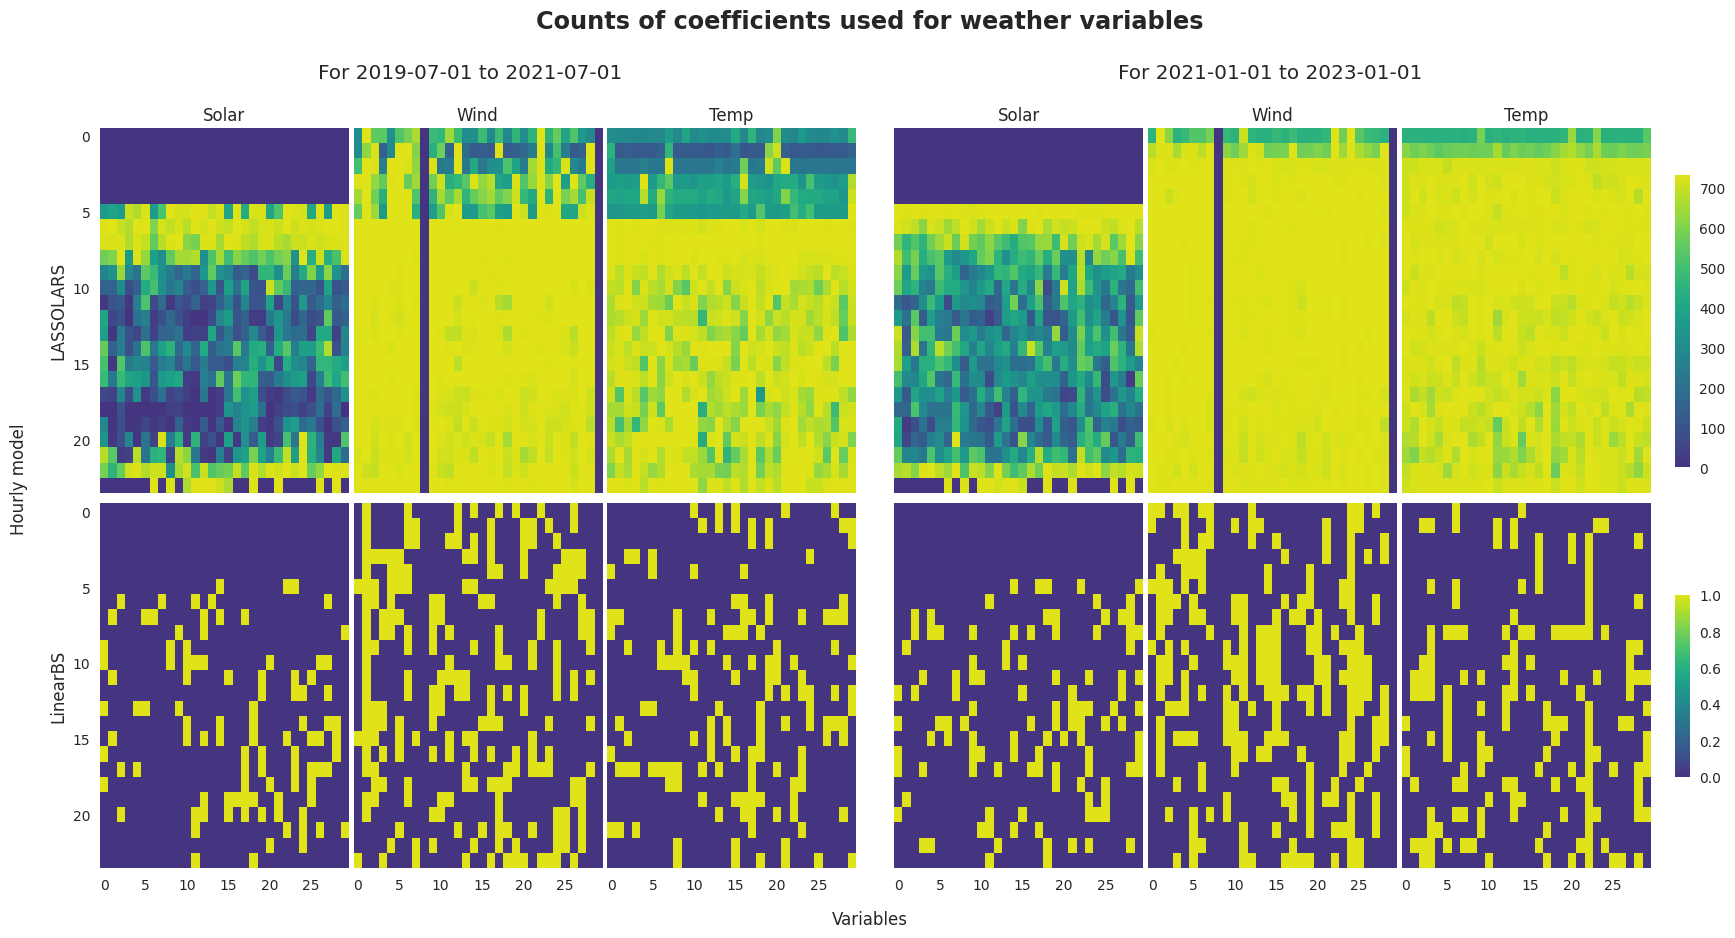

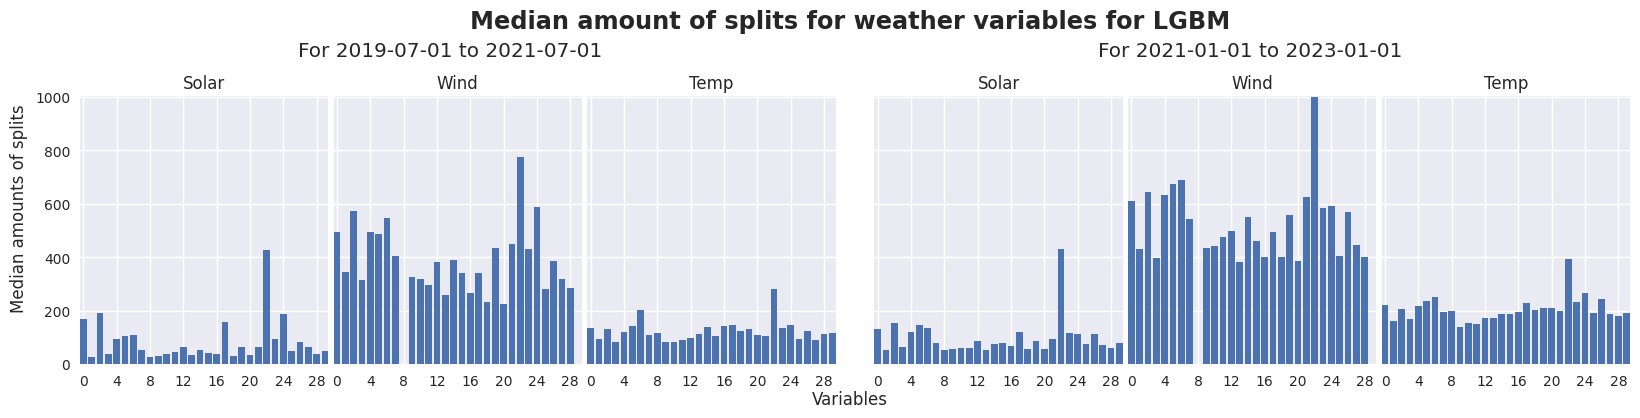

In [18]:
lin_dfs = [LARS_per1, BW_per1, LARS_per2, BW_per2]
for lin_df in lin_dfs:
    lin_df["Holstebro_wind"] = np.zeros(24)
    lin_df["Århus_wind"] = np.zeros(24)

lightgbm_per1["Holstebro_wind"] = np.zeros(731)
lightgbm_per1["Århus_wind"] = np.zeros(731)
lightgbm_per2["Holstebro_wind"] = np.zeros(730)
lightgbm_per2["Århus_wind"] = np.zeros(730)

cols = LARS_per1.columns.values

solar = sorted([x for x in cols if 'solar' in x])
wind = sorted([x for x in cols if 'wind' in x])
temp = sorted([x for x in cols if 'temp' in x])

grouped_var = [solar, wind, temp]
names = ['Solar', 'Wind', 'Temp']
method = ['LARS', 'BW']
dfs_period1 = [LARS_per1, BW_per1]
dfs_period2 = [LARS_per2, BW_per2]
title = 'Counts of coefficients used for weather variables'

create_one_coef_plot(dfs_period1, dfs_period2, grouped_var, names, method, title, c1=[1.1, 1.1, 0.06, 0.8], c2=[1.1, 0.25, 0.06, 0.5])
plt.savefig('plots/coeff_plot_weather.png', bbox_inches='tight')
plt.show()

title = "Median amount of splits for weather variables for LGBM"
create_one_count_plot(lightgbm_per1, lightgbm_per2, grouped_var, names, title)
plt.savefig('plots/count_plot_weather.png', bbox_inches='tight')
plt.show()

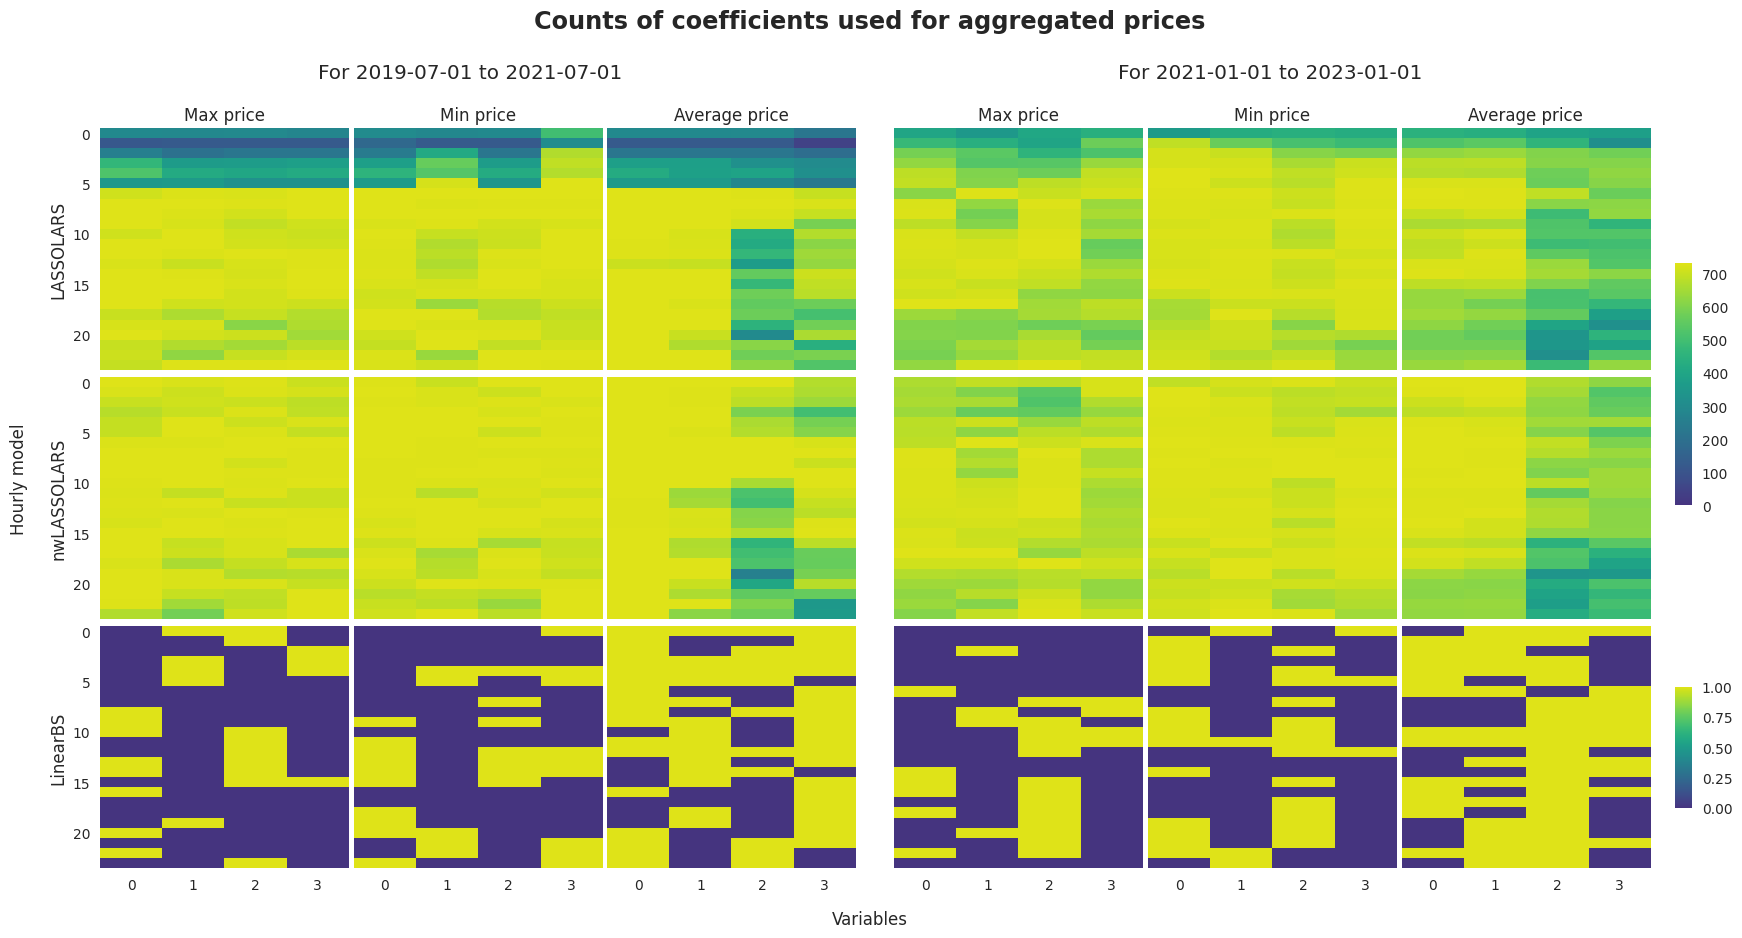

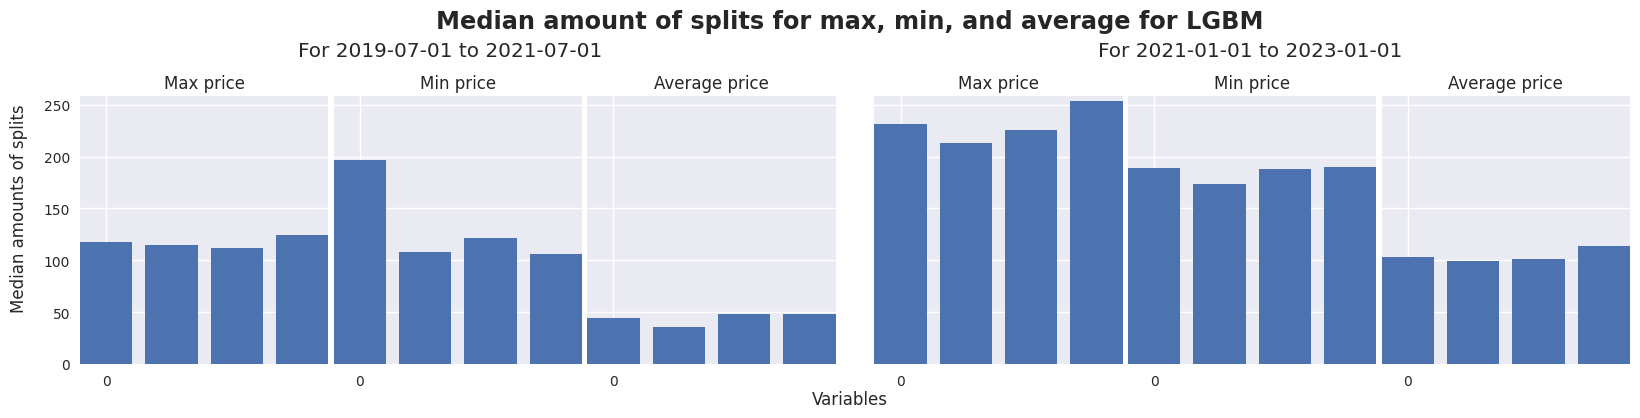

In [19]:
Max = [x for x in X if 'Max' in x]
Min = [x for x in X if 'Min' in x]
Avg = [x for x in X if 'Avg' in x]

grouped_var = [Max, Min, Avg]
names = ['Max price', 'Min price', 'Average price']
method = ['LARS', 'LARSnw','BW']
dfs_period1 = [LARS_per1, LARSnw_per1, BW_per1]
dfs_period2 = [LARS_per2, LARSnw_per2, BW_per2]


title = 'Counts of coefficients used for aggregated prices'
create_one_coef_plot(dfs_period1, dfs_period2, grouped_var, names, method, title, c1=[1.1, 1.5, 0.07, 1], c2=[1.1, 0.25, 0.07, 0.5])
plt.savefig('plots/coeff_plot_aggr.png', bbox_inches='tight')
plt.show()

title = "Median amount of splits for max, min, and average for LGBM"
create_one_count_plot(lightgbm_per1, lightgbm_per2, grouped_var, names, title)
plt.savefig('plots/count_plot_aggre.png', bbox_inches='tight')
plt.show()

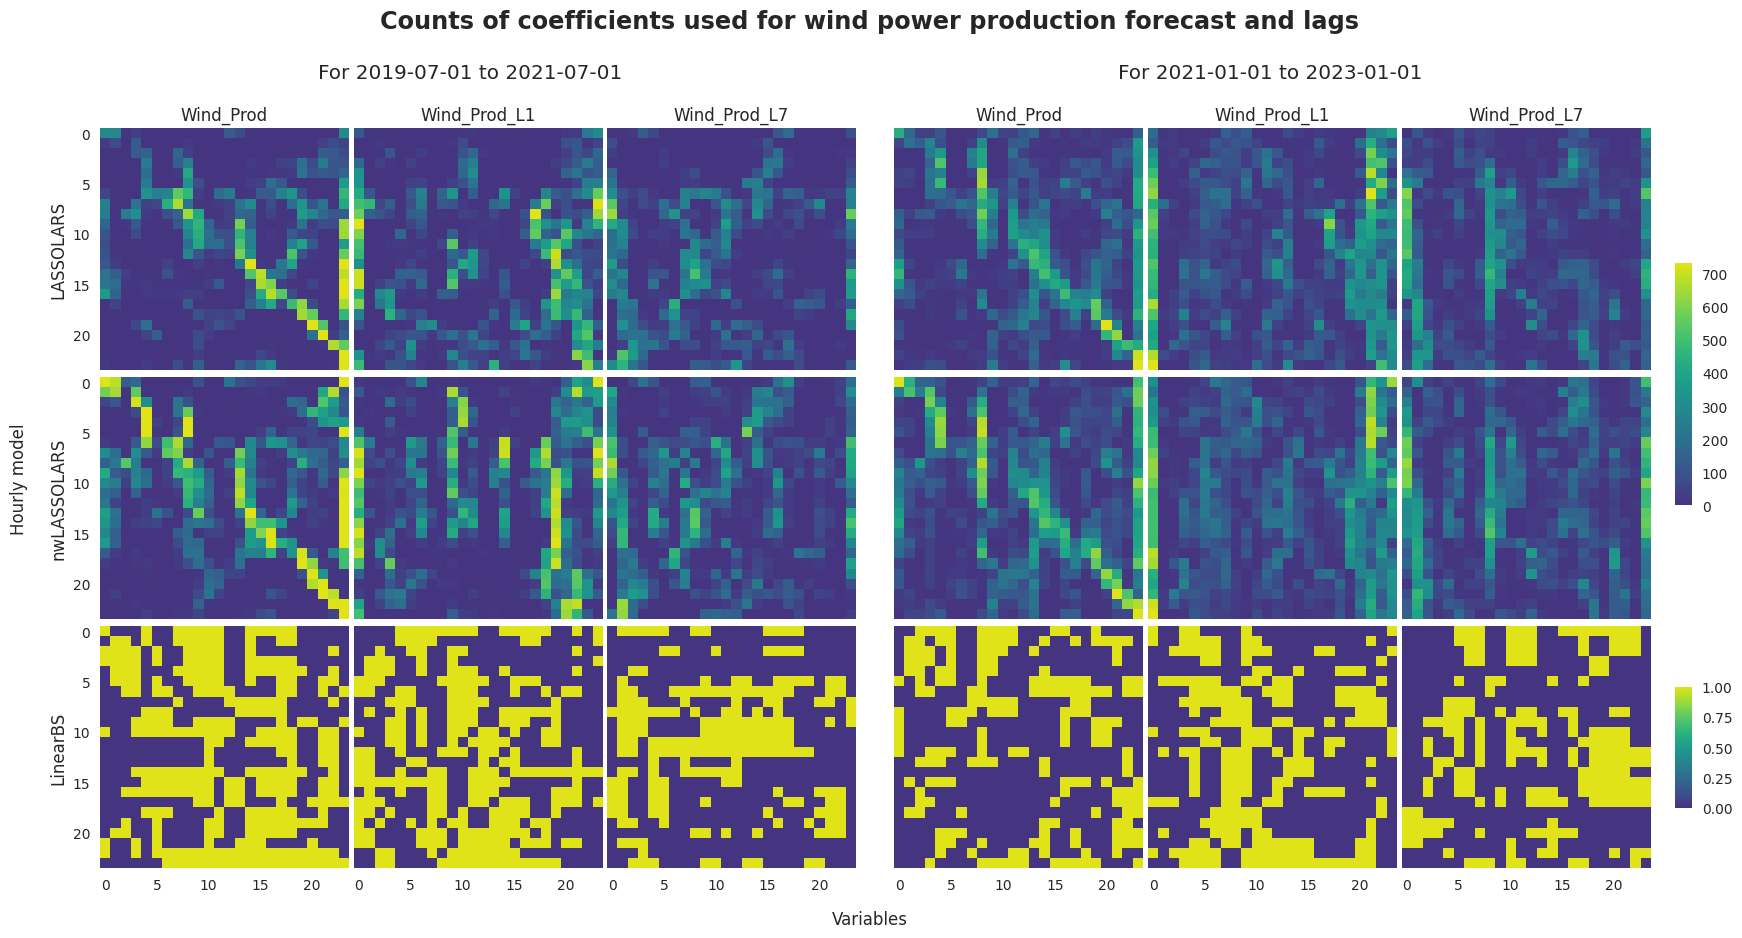

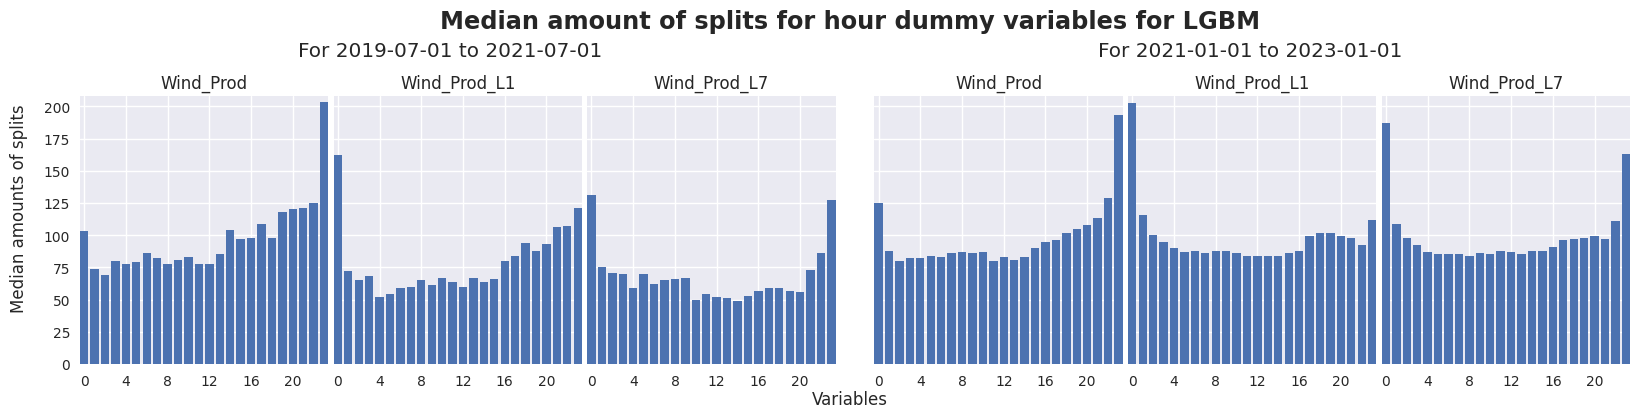

In [20]:
wind_prod = [x for x in X if 'Wind' in x and 'lag' not in x]
wind_prod_lag1 = [x for x in X if 'Wind' in x and 'lag1' in x]
wind_prod_lag7 = [x for x in X if 'Wind' in x and 'lag7' in x]

grouped_var = [wind_prod, wind_prod_lag1, wind_prod_lag7]
names = ['Wind_Prod', 'Wind_Prod_L1', 'Wind_Prod_L7']
method = ['LARS', 'LARSnw','BW']
dfs_period1 = [LARS_per1, LARSnw_per1, BW_per1]
dfs_period2 = [LARS_per2, LARSnw_per2, BW_per2]
title = 'Counts of coefficients used for wind power production forecast and lags'

create_one_coef_plot(dfs_period1, dfs_period2, grouped_var, names, method, title, c1=[1.1, 1.5, 0.07, 1], c2=[1.1, 0.25, 0.07, 0.5])
plt.savefig('plots/coeff_plot_wind_prod.png', bbox_inches='tight')
plt.show()
title = "Median amount of splits for hour dummy variables for LGBM"
create_one_count_plot(lightgbm_per1, lightgbm_per2, grouped_var, names, title)
plt.savefig('plots/count_plot_wind_prod.png', bbox_inches='tight')
plt.show()

## LightGBM's use of 24H dummy varaibles

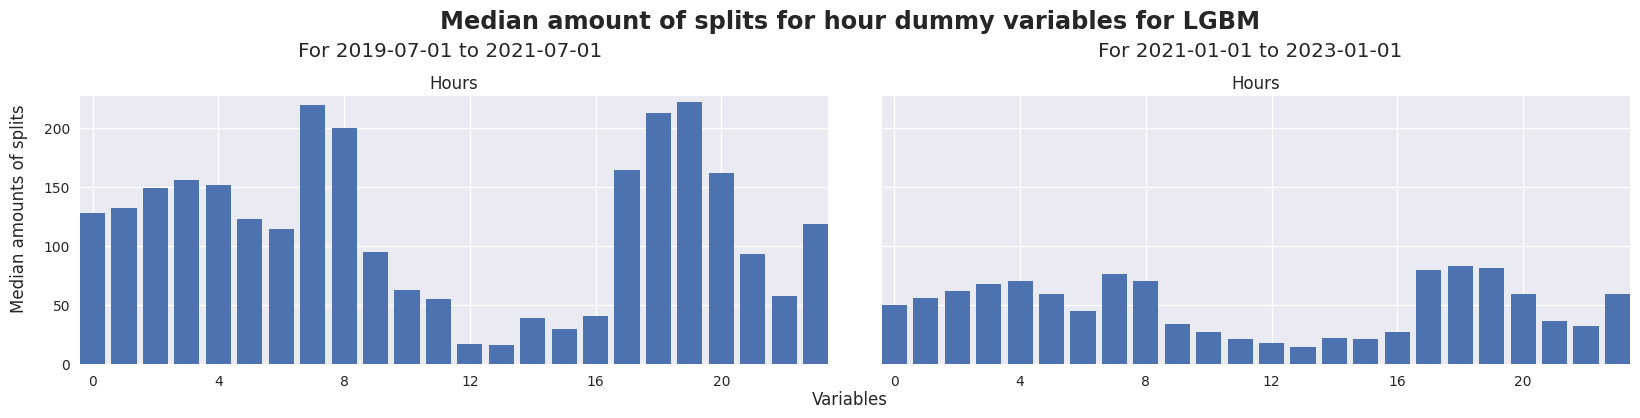

In [21]:
with open('results\coef_results\LightGBMallbayes_Period1_Year3.txt', 'rb') as fp:
    lightgbm_per1, X_gbm = pickle.load(fp)
lightgbm_per1 = pd.DataFrame(lightgbm_per1, columns = X_gbm)

with open('results\coef_results\LightGBMallbayes_Period2_Year3.txt', 'rb') as fp:
    lightgbm_per2, X_gbm = pickle.load(fp)
lightgbm_per2 = pd.DataFrame(lightgbm_per2, columns = X_gbm)

Hours = [x for x in X_gbm if 'Hour_' in x]
names = ['Hours']

title = "Median amount of splits for hour dummy variables for LGBM"
create_one_count_plot(lightgbm_per1, lightgbm_per2, [Hours], names, title)
plt.savefig('plots/count_plot_hour.png', bbox_inches='tight')
plt.show()


# Weather stations

In [22]:
from texttable import Texttable
import latextable

df = pd.read_csv("data/training_data.csv", sep = ";")

wind_col = {p.split('_')[0] for p in df.columns.values if "wind" in p}
solar_col = {p.split('_')[0] for p in df.columns.values if "solar" in p}
temp_col = {p.split('_')[0] for p in df.columns.values if "temp" in p}

cities = wind_col.union(solar_col)
cities = temp_col.union(cities)
cities = sorted(cities)
rows = []
header = ['Number', 'City', 'Wind speed', 'Solar irradiance', 'Temperature']
i = 0
for city in cities:
    row = [city] + ['(Y)' if city in wind_col else '(N)'] + ['(Y)' if city in solar_col else '(N)'] + ['(Y)' if city in temp_col else '(N)']
    rows.append([i] + row)
    i += 1

rows = [header] + rows
table = Texttable()
table.set_cols_align(['l']+ ["c"] * (len(header)-1))
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

cap = 'Locations for weather forecasts. (Y) indicates that the location has been availiable for the given forecast and (N) indicates that it has not.'
lab = 'table:weather'

print(latextable.draw_latex(table, caption=cap, label=lab))

\begin{table}
	\begin{center}
		\begin{tabular}{l|c|c|c|c}
			Number & City & Wind speed & Solar irradiance & Temperature \\
			\hline
			0 & Augustenborg & (Y) & (Y) & (Y) \\
			1 & Brande & (Y) & (Y) & (Y) \\
			2 & Esbjerg & (Y) & (Y) & (Y) \\
			3 & Haderslev & (Y) & (Y) & (Y) \\
			4 & Hedehusene & (Y) & (Y) & (Y) \\
			5 & Helsingør & (Y) & (Y) & (Y) \\
			6 & Hjørring & (Y) & (Y) & (Y) \\
			7 & Holbæk & (Y) & (Y) & (Y) \\
			8 & Holstebro & (N) & (Y) & (Y) \\
			9 & Horsens & (Y) & (Y) & (Y) \\
			10 & Ikast & (Y) & (Y) & (Y) \\
			11 & Jammerbugt & (Y) & (Y) & (Y) \\
			12 & Lemvig & (Y) & (Y) & (Y) \\
			13 & Løgstør & (Y) & (Y) & (Y) \\
			14 & Løkken & (Y) & (Y) & (Y) \\
			15 & Mariagerfjord & (Y) & (Y) & (Y) \\
			16 & Middelfart & (Y) & (Y) & (Y) \\
			17 & Nakskov & (Y) & (Y) & (Y) \\
			18 & Nibe & (Y) & (Y) & (Y) \\
			19 & Næstved & (Y) & (Y) & (Y) \\
			20 & Odense & (Y) & (Y) & (Y) \\
			21 & Ringkøbing & (Y) & (Y) & (Y) \\
			22 & Rønne & (Y) & (Y) & (Y) \\
			23 

In [23]:
temp

['Augustenborg_temp',
 'Brande_temp',
 'Esbjerg_temp',
 'Haderslev_temp',
 'Hedehusene_temp',
 'Helsingør_temp',
 'Hjørring_temp',
 'Holbæk_temp',
 'Holstebro_temp',
 'Horsens_temp',
 'Ikast_temp',
 'Jammerbugt_temp',
 'Lemvig_temp',
 'Løgstør_temp',
 'Løkken_temp',
 'Mariagerfjord_temp',
 'Middelfart_temp',
 'Nakskov_temp',
 'Nibe_temp',
 'Næstved_temp',
 'Odense_temp',
 'Ringkøbing_temp',
 'Rønne_temp',
 'Sakskøbing_temp',
 'Skærbæk_temp',
 'Svendborg_temp',
 'Thisted_temp',
 'Vejen_temp',
 'Viborg_temp',
 'Århus_temp']

# Cross validation results

['lightGBMallbayes_Period1_Year3.txt', 'lightGBMallbayes_Period2_Year3.txt']


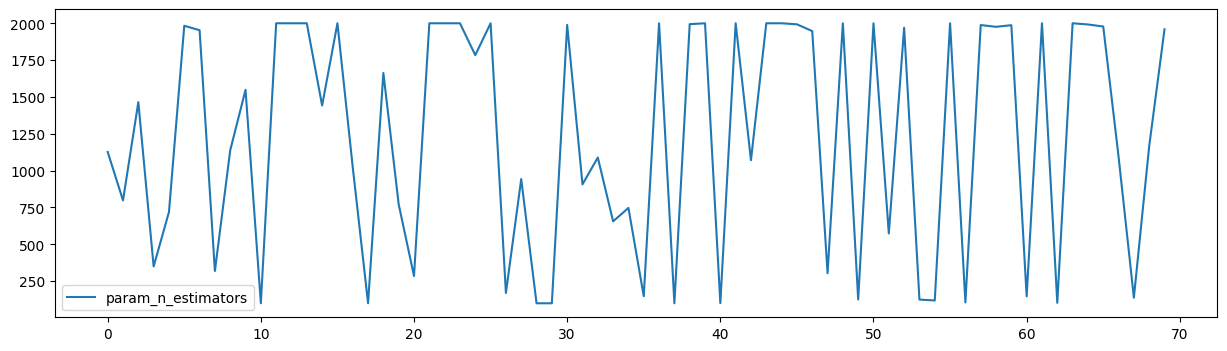

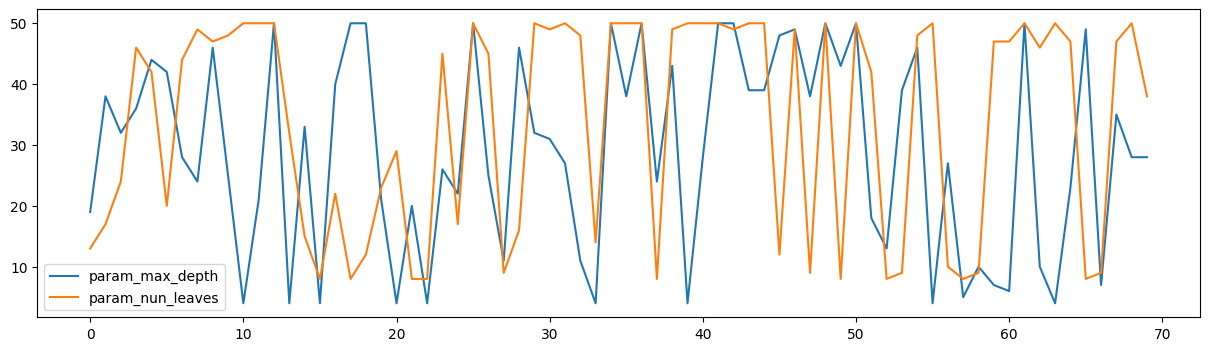

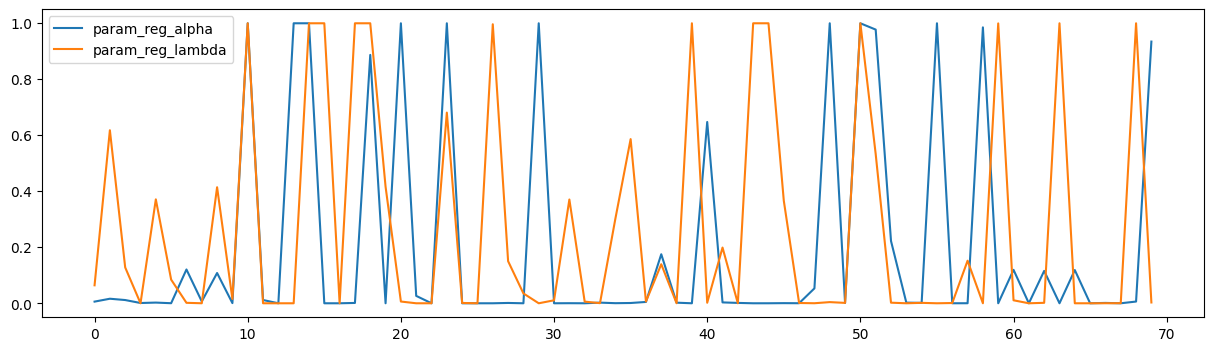

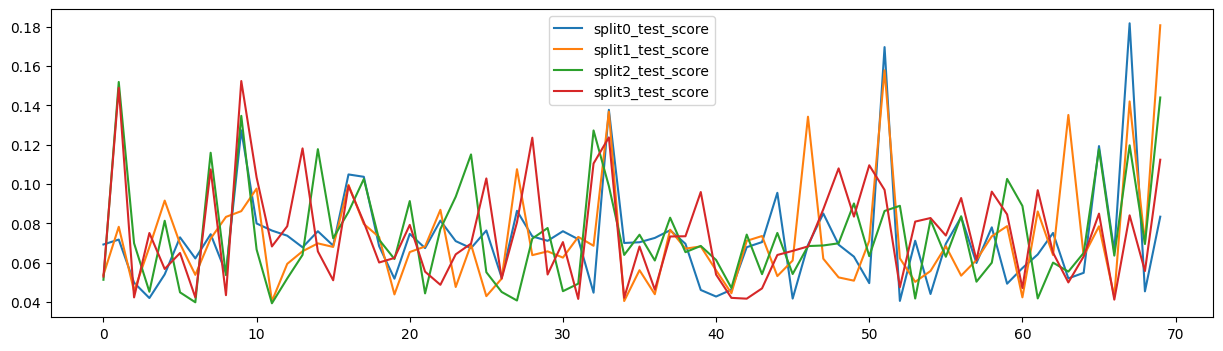

41
{
    "learning_rate": 0.1,
    "max_depth": 50,
    "min_child_samples": 50,
    "n_estimators": 2000,
    "num_leaves": 50,
    "reg_alpha": 0.0031202134384625984,
    "reg_lambda": 0.19879296322348888
}


In [24]:
def create_cv_plot(cv_res):
    res_to_plot = [(ma.getdata(cv_res[res]), res) for res in cv_res if 'param_' in res and 'param_n_estimators' not in res]

    with plt.rc_context({'figure.figsize':(15,4)}):
        plt.plot(ma.getdata(cv_res['param_n_estimators']), label='param_n_estimators')
        plt.legend()
        plt.show()

    with plt.rc_context({'figure.figsize':(15,4)}):
        plt.plot(ma.getdata(cv_res['param_max_depth']), label='param_max_depth')
        plt.plot(ma.getdata(cv_res['param_num_leaves']), label='param_nun_leaves')
        plt.legend()
        plt.show()

    with plt.rc_context({'figure.figsize':(15,4)}):
        plt.plot(ma.getdata(cv_res['param_reg_alpha']), label='param_reg_alpha')
        plt.plot(ma.getdata(cv_res['param_reg_lambda']), label='param_reg_lambda')
        plt.legend()
        plt.show()

    res_to_plot = [(ma.getdata(cv_res[res]), res) for res in cv_res if 'split' in res]

    #with plt.style.context('seaborn'):
    with plt.rc_context({'figure.figsize':(15,4)}):
        for values, name in res_to_plot:
            plt.plot(-1*values, label=name)
        plt.legend()

path = 'results/cv_results'
files = [f for f in listdir(path) if isfile(join(path, f)) if 'bayes' in f]
print(files)

with open (join(path, files[1]), 'rb') as fp:
    cv_res = pickle.load(fp)

c_cv_res = cv_res[1]
create_cv_plot(c_cv_res)
plt.show()

c_cv_res['rank_test_score']
n_best = 1
n_best = np.argsort(c_cv_res['rank_test_score'])[0:n_best]
import json
best = [c_cv_res['params'][index] for index in n_best]
for b,n in zip(best, n_best):
    print(n)
    print(json.dumps(b, indent=4))

In [25]:
with open('results\LightGBMallbayes_Period1_Year3.txt', 'rb') as fp:
    y_pred1, y_true1 = pickle.load(fp)


with open('results\LightGBMallbayes_Period2_Year3.txt', 'rb') as fp:
    y_pred2, y_true2 = pickle.load(fp)

error1 = y_pred1-y_true1
error2 = y_pred2-y_true2


path = 'results/training_set_results'
files = [f for f in listdir(path) if isfile(join(path, f)) if 'bayes' in f]

with open (join(path, files[0]), 'rb') as fp:
    scores1 = pickle.load(fp)

with open (join(path, files[1]), 'rb') as fp:
    scores2 = pickle.load(fp)

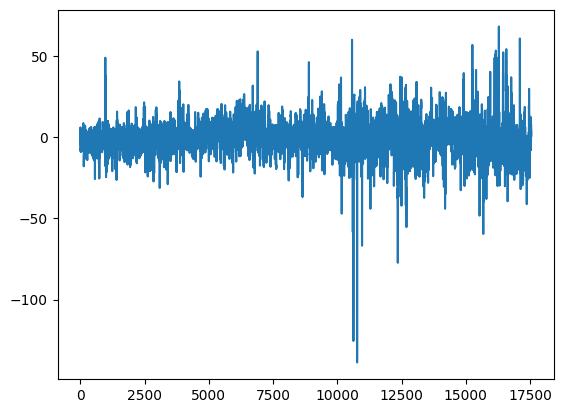

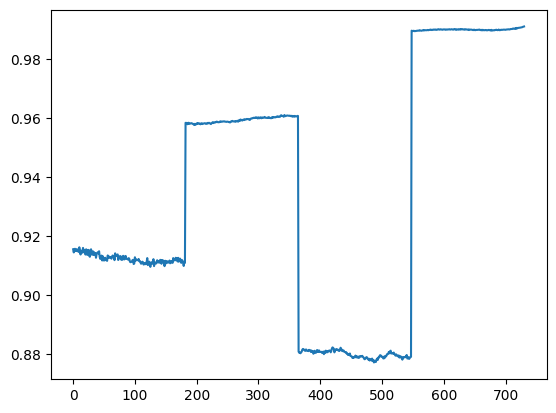

In [30]:
plt.plot(error1)
plt.show()

plt.plot(scores1)
plt.show()

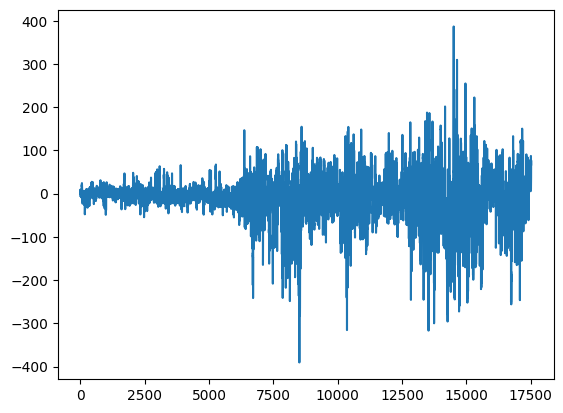

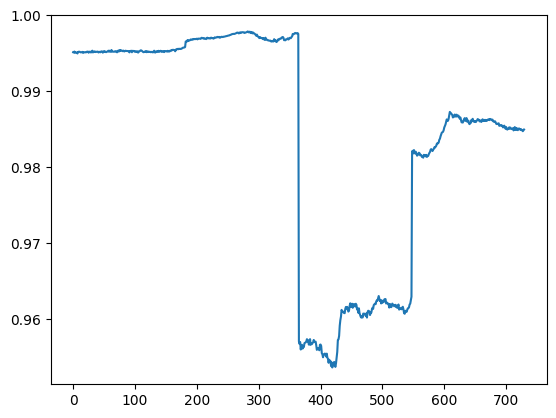

In [29]:
plt.plot(error2)
plt.show()

plt.plot(scores2)
plt.show()